### 1. 导入完成主成分分析和聚类所需要的包

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from A06_PCA import DimensionReduce, show_scree_plot, show_correlation_plot
from A07_KMeans import Clustering
from A06_StandardScaler import Standard
from ShowClusterScatter import show_class_result
from ShowSilhouette import show_silhouette_plot
import warnings
import joblib

warnings.filterwarnings('ignore')

plt.rc('font', family='Times New Roman')


### 2. 读取加速、减速事件数据内容

In [2]:
acc_data = pd.read_csv(
    '../GpsData/BasicData/加速制动事件/gps加速事件提取附加车辆信息.csv')
# 提取重型货车数据
acc_data = acc_data[(acc_data['car_type'] == '重型货车')].reset_index(drop=True)
acc_data = acc_data[acc_data['max_acc_lon'] < 5].reset_index(drop=True)
acc_data['logo'] = '加速事件'


In [3]:
dec_data = pd.read_csv(
    '../GpsData/BasicData/加速制动事件/gps制动事件提取附加车辆信息.csv')
# 提取重型货车数据
dec_data = dec_data[(dec_data['car_type'] == '重型货车')].reset_index(drop=True)
dec_data = dec_data[dec_data['max_dec_lon'] < 5].reset_index(drop=True)
dec_data['logo'] = '刹车事件'


### 3. 一阶段速度聚类
#### 对加速和刹车事件速度特征['max_v','mean_v', 'std_v', 'min_v', 'duration']进行标准化后一阶段聚类分析
#### 通过降维对降维后的数据可视化

In [4]:
data = pd.concat([acc_data,dec_data],axis=0).reset_index(drop=True)

#### 3.1 速度特征标准化

In [5]:
# 读取标准化后的一级聚类特征数据
speed_index = data[['max_v','mean_v', 'std_v', 'min_v','duration']]
speed_ss = Standard(speed_index)
ss_speed_index = speed_ss.out_scaled_result()
# 速度聚类模型保存
joblib.dump(speed_ss,'../GpsData/两阶段聚类_New/一阶段速度聚类/速度_时间相关指标_数据标准化模型.pkl') 

['../GpsData/两阶段聚类_New/一阶段速度聚类/速度_时间相关指标_数据标准化模型.pkl']

In [6]:
ss_speed_index.columns = ['ss_'+i for i in ss_speed_index.columns.to_list()]
ss_speed_index

,ss_max_v,ss_mean_v,ss_std_v,ss_min_v,ss_duration
0,-1.400024,-1.341252,-0.535997,-1.225768,1.494373
1,-1.524286,-1.455157,-0.549466,-1.268858,-0.250432
2,-1.264465,-1.119074,-0.947820,-0.870277,-0.056565
3,-0.897327,-0.749346,-0.867648,-0.584808,0.912771
4,-0.671397,-0.535384,-0.861533,-0.310110,0.331169
...,...,...,...,...,...
430275,0.955306,0.313650,3.371295,-0.283179,0.912771
430276,-0.609266,-0.881868,1.942830,-1.188065,-0.444300
430277,0.079824,0.149164,-0.560810,0.239285,1.494373
430278,0.480851,0.276794,3.579387,-0.913367,0.525037


#### 3.2 基于标准化后的的特征进行聚类，返回聚类结果

In [7]:
data = pd.concat([data, ss_speed_index], axis=1)
# 创建加速、减速事件的聚类类
speed_clus = Clustering(data[ss_speed_index.columns.to_list(
)], calc_best_cluster_flag=False, max_cluster=4, best_cluster=2)
print('完成聚类')
if speed_clus.calc_best_cluster_flag:
    speed_clus.show_silhouette_clusters()
    print('轮廓系数：{}'.format(speed_clus.silhouette_scores))
    plt.savefig('../GpsFigure/两阶段聚类_New/一阶段速度聚类/速度相关指标_聚类数与轮廓系数图.pdf')
data['v_label'] = speed_clus.best_labels
data.to_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/速度相关指标_聚类结果.xlsx', index=False)

# 速度聚类模型保存
joblib.dump(speed_clus, '../GpsData/两阶段聚类_New/一阶段速度聚类/速度相关指标__聚类模型.pkl')


完成聚类


['../GpsData/两阶段聚类_New/一阶段速度聚类/速度相关指标__聚类模型.pkl']

#### 3.3 标准化速度特征进行降维,追加至加速事件原始数据中

In [8]:
# 创建加速事件PCA降维类
speed_dr = DimensionReduce(ss_speed_index, n_pc=2)
speed_tve = speed_dr.calc_total_variance_explain()
speed_tve.to_excel(
    '../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分总解释方差.xlsx', index=False)

speed_rc_load = speed_dr.calc_RC_loadings()
speed_rc_load.to_excel(
    '../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分旋转载荷.xlsx', index=True)

data = pd.concat([data, speed_dr.pcs], axis=1)
data = data.rename(columns={'PC1': 'v_PC1', 'PC2': 'v_PC2'})
data.to_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx', index=False)

# 速度PCA降维模型保存
joblib.dump(speed_dr, '../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl')


['../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl']

#### 3.4 可视化聚类轮廓系数结果

The average silhouette score of all samples:  0.4495223554851797
The average silhouette score of cluster 0 : 0.45
The average silhouette score of cluster 1 : 0.44


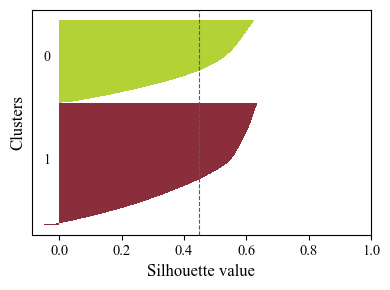

In [12]:
data = pd.read_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_主成分结果.xlsx')
cls_list = list(data[['max_v', 'mean_v', 'std_v', 'min_v','duration', 'v_label']].groupby(
    'v_label').mean().sort_values(by='max_v').index)
show_silhouette_plot(data.sample(n=100000, random_state=42), x_cols=['v_PC1', 'v_PC2'], y_col='v_label',
                     num_cls=2, cls_list=cls_list, colors=['#8a2e3b', '#b2d235', '#dea32c', '#6950a1'])
plt.savefig('../GpsFigure/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_最优聚类轮廓图.png', dpi=1200)

#### 3.5 可视化聚类散点图

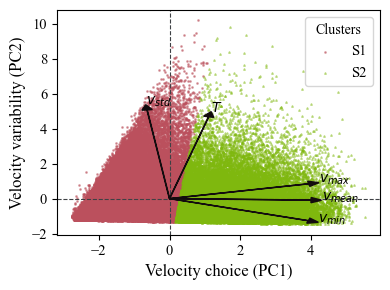

In [11]:
speed_dr = joblib.load('../GpsData/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_PCA模型.pkl')
cls_list = list(data[['max_v', 'mean_v', 'std_v', 'min_v', 'duration', 'v_label']].groupby(
    'v_label').mean().sort_values(by='max_v').index)

show_class_result(data.sample(100000, random_state=42), PC_list=['v_PC1', 'v_PC2'], label='v_label',
                  pca=speed_dr.pca, num_cls=2, feature_num=5,
                  arrow_text_list=[
                      r'$v_{max}$', r'$v_{mean}$', r'$v_{std}$', r'$v_{min}$', '$T$'],
                  xy_labels=[
                      'Velocity choice (PC1)', 'Velocity variability (PC2)'],
                  cls_list=cls_list, cls_legend=['S1', 'S2'], cls_colors=['#bb505d', '#7fb80e', '#4e72b8'],
                  vector_scale=1.5)

plt.savefig('../GpsFigure/两阶段聚类_New/一阶段速度聚类/标准化速度相关指标_聚类散点图.png', dpi=1200)


#### 3.6 求解速度聚类中心点

In [13]:
centers = speed_clus.best_kmeans.cluster_centers_
x_centers = speed_ss.scaler.inverse_transform(centers)
x_centers = pd.DataFrame(x_centers, columns=speed_index.columns)
x_centers.to_excel('../GpsData/两阶段聚类_New/一阶段速度聚类/速度相关指标_聚类中心点.xlsx', index=False)

In [14]:
x_centers

,max_v,mean_v,std_v,min_v,duration
0,67.545065,63.002276,3.359817,58.172620,10.236552
1,38.445142,32.599226,4.566016,25.959829,8.652699
